# The basics of creating fox hunting sheaves
(c) 2019 Michael Robinson

Importing the essentials

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysheaf as ps
import networkx as nx

Importing the fox hunting sheaf library and the simulator

In [2]:
import fox_sheaf
import generate_data

Here is the fox (at the origin) and one receiver.  For simplicity, let's say that the receiver makes perfect measurements

In [3]:
fox = generate_data.Transmitter(location=np.array([0.,0.]),power=1.0,identity='A')
rx1 = generate_data.Receiver()

Let's create a sheaf for a single bearing measurement of the fox

In [4]:
bearing_sheaf=fox_sheaf.FoxSheaf(['bearing'],[rx1])

Here's a plot of the partial order that the sheaf is based upon

([], <a list of 0 Text yticklabel objects>)

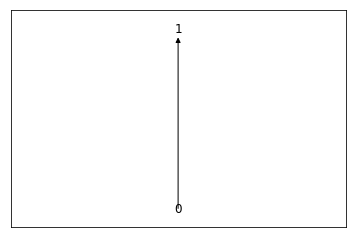

In [5]:
pos=nx.nx_agraph.pygraphviz_layout(bearing_sheaf,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(bearing_sheaf,pos)
nx.draw_networkx_edges(bearing_sheaf,pos)
plt.xticks([])
plt.yticks([])

It is pretty boring, because `FoxSheaf` builds out reception reports, not just receivers!  

The cell labeled `0` is the virtual observation containg all data about the fox, while `1` contains the fox location only 

Now let's add some data!  To that end, we need the simulator to generate `ReceptionReports` for us.  We format this into a small assignment in which the receiver is getting a bearing consistent with a proposed location of the fox

In [6]:
rx1.add_reception(location=np.array([1,0]),time=0.,transmitter=fox)
bearing_sheaf=fox_sheaf.FoxSheaf(['bearing'],[rx1])

Plotting again.  Now we have additionally a cell `2` that contains all the data about the receiver and the fox (a virtual observation) and `3`, containing data about just the reception report itself

([], <a list of 0 Text yticklabel objects>)

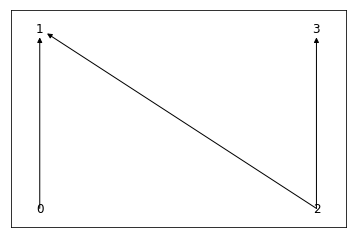

In [7]:
pos=nx.nx_agraph.pygraphviz_layout(bearing_sheaf,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(bearing_sheaf,pos)
nx.draw_networkx_edges(bearing_sheaf,pos)
plt.xticks([])
plt.yticks([])

Here's a readout of all the data at each cell.  PySheaf demands that assignments have types, and it checks the types.  This is not terribly sophisticated, but helps to avoid silly mistakes.  It's helpful here so that you can interpret the stalks

In [8]:
for cell in bearing_sheaf.GetCellIndexList():
    print('Cell {} : Type {} : Assignment {}'.format(cell,bearing_sheaf.GetCell(cell).mDataTagType,bearing_sheaf.GetCell(cell).mDataAssignment))

Cell 0 : Type foxloc_power : Assignment [ 0.69964653 -1.28997481 -1.47981995]
Cell 1 : Type foxloc : Assignment [0.04428765 0.42202917]
Cell 2 : Type foxloc_rxloc : Assignment [-0.8388512   0.91297251  1.          0.        ]
Cell 3 : Type bearing_rxloc : Assignment [  1.   0. -90.]


Wait!  Why is the assignment random garbage for the fox location?  Oh right, we haven't told the `FoxSheaf` constructor about the fox.  Indeed, the `FoxSheaf` constructor pre-fills all virtual observations with random values, so that the optimizers can start from a random initial guess.

So let's temporarily put the fox location into the assignment. We'll mark this as a true observation so that PySheaf doesn't change it

In [9]:
bearing_sheaf.GetCell(1).SetDataAssignment(ps.Assignment('foxloc',np.array([0,0])))
bearing_sheaf.GetCell(1).mOptimizationCell = False

Propagate the assignment out to the virtual observations with the `FuseAssignment()` method

In [10]:
bearing_sheaf.FuseAssignment()

     fun: 1.8474747051068568e-05
     jac: array([-4.05774588e-01, -5.71800908e-02,  0.00000000e+00,  4.05013959e-02,
       -5.26225467e+01, -8.80493858e-01,  5.25063208e+01])
 message: 'Optimization terminated successfully.'
    nfev: 392
     nit: 37
    njev: 37
  status: 0
 success: True
       x: array([-8.91573099e-06, -2.81338848e-06, -1.47981995e+00, -4.10142854e-06,
       -8.88625058e-06,  9.99994503e-01, -8.92309974e-06])

OK, now what's the consistency radius?  It should be small!

In [11]:
bearing_sheaf.ComputeConsistencyRadius()

1.8474747051068568e-05

In [12]:
for cell in bearing_sheaf.GetCellIndexList():
    print('Cell {} : Type {} : Assignment {}'.format(cell,bearing_sheaf.GetCell(cell).mDataTagType,bearing_sheaf.GetCell(cell).mDataAssignment))

Cell 0 : Type foxloc_power : Assignment [-8.91573099e-06 -2.81338848e-06 -1.47981995e+00]
Cell 1 : Type foxloc : Assignment [0 0]
Cell 2 : Type foxloc_rxloc : Assignment [-4.10142854e-06 -8.88625058e-06  9.99994503e-01 -8.92309974e-06]
Cell 3 : Type bearing_rxloc : Assignment [  1.   0. -90.]


Let's change the bearing and see what happens...  The stalk over the bearing reception report consists of a vector of `[receiver x, receiver y, bearing]`

In [13]:
bearing_sheaf.GetCell(3).SetDataAssignment(ps.Assignment('bearing_rxloc',np.array([1.0,0.0, 45])))
bearing_sheaf.FuseAssignment()
bearing_sheaf.ComputeConsistencyRadius()

15.945924122223918

The consistency radius is now substantially larger.  It's not 45 degrees, because the optimizer in `FuseAssignment()` tried moving the fox transmitter a bit, as the following shows!

In [14]:
for cell in bearing_sheaf.GetCellIndexList():
    print('Cell {} : Type {} : Assignment {}'.format(cell,bearing_sheaf.GetCell(cell).mDataTagType,bearing_sheaf.GetCell(cell).mDataAssignment))

Cell 0 : Type foxloc_power : Assignment [ -5.99084179 -10.85048887  -1.47981995]
Cell 1 : Type foxloc : Assignment [0 0]
Cell 2 : Type foxloc_rxloc : Assignment [-5.81063651 -0.09982078 -5.81077351 -0.09995769]
Cell 3 : Type bearing_rxloc : Assignment [ 1.  0. 45.]


Let's create a sheaf for a single Received Signal Strength Indication (RSSI) measurement of the fox.  The partial order does not look the same as before, because this measurement requires knowledge of the fox transmitter power.

([], <a list of 0 Text yticklabel objects>)

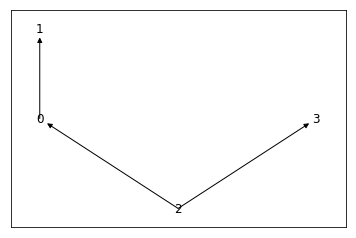

In [15]:
rssi_sheaf=fox_sheaf.FoxSheaf(['rssi'],[rx1])
pos=nx.nx_agraph.pygraphviz_layout(rssi_sheaf,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(rssi_sheaf,pos)
nx.draw_networkx_edges(rssi_sheaf,pos)
plt.xticks([])
plt.yticks([])

Here is a larger sheaf consisting of two bearing and two RSSI measurements.  Just for simplicity, we'll let four new `Receiver`s get the data for us

([], <a list of 0 Text yticklabel objects>)

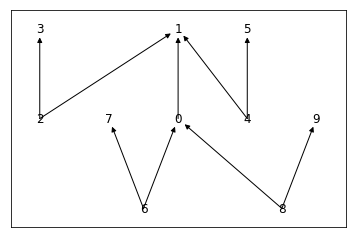

In [16]:
fox=generate_data.Transmitter(location=np.array([0.5,0.5]),power=1.0,identity='A')
rx1=generate_data.Receiver()
rx1.add_reception(time=0.0,location=np.array([1,0]),transmitter=fox)
rx2=generate_data.Receiver()
rx2.add_reception(time=0.0,location=np.array([1,1]),transmitter=fox)
rx3=generate_data.Receiver()
rx3.add_reception(time=0.0,location=np.array([0,0]),transmitter=fox)
rx4=generate_data.Receiver()
rx4.add_reception(time=0.0,location=np.array([0,0.5]),transmitter=fox)

hunting_sheaf=fox_sheaf.FoxSheaf(['bearing','bearing','rssi','rssi'],[rx1,rx2,rx3,rx4])
pos=nx.nx_agraph.pygraphviz_layout(hunting_sheaf,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(hunting_sheaf,pos)
nx.draw_networkx_edges(hunting_sheaf,pos)
plt.xticks([])
plt.yticks([])

Let's load up a global section

In [17]:
hunting_sheaf.GetCell(0).SetDataAssignment(ps.Assignment('foxloc_power',np.array([0.5,0.5,1.0])))
hunting_sheaf.GetCell(1).SetDataAssignment(ps.Assignment('foxloc',np.array([0.5,0.5])))
hunting_sheaf.GetCell(2).SetDataAssignment(ps.Assignment('foxloc_rxloc',np.array([0.5,0.5,1,0])))
hunting_sheaf.GetCell(3).SetDataAssignment(ps.Assignment('bearing_rxloc',np.array([1,0,-45])))
hunting_sheaf.GetCell(4).SetDataAssignment(ps.Assignment('foxloc_rxloc',np.array([0.5,0.5,1,1])))
hunting_sheaf.GetCell(5).SetDataAssignment(ps.Assignment('bearing_rxloc',np.array([1,1,-135])))
hunting_sheaf.GetCell(6).SetDataAssignment(ps.Assignment('foxloc_power_rxloc',np.array([0.5,0.5,0,0,1])))
hunting_sheaf.GetCell(7).SetDataAssignment(ps.Assignment('rssi_rxloc',np.array([0,0,0.16])))
hunting_sheaf.GetCell(8).SetDataAssignment(ps.Assignment('foxloc_power_rxloc',np.array([0.5,0.5,0.5,1,1])))
hunting_sheaf.GetCell(9).SetDataAssignment(ps.Assignment('rssi_rxloc',np.array([0.5,1,0.32])))

for c in hunting_sheaf.GetCellIndexList(): hunting_sheaf.MaximallyExtendCell(c) 
hunting_sheaf.ComputeConsistencyRadius()

0.0018896046913778324

Its consistency radius is small, but not zero, due to roundoff error